# Logistic Regression
*Daniel Öman & Xander Yoon*

Import Dependencies

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import sqlite3
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import warnings
import seaborn as sns
from sklearn.inspection import permutation_importance
from helpers import train_test, evaluate, logistic_regression, polynomial_features, poly_enhance_data, train_test_error, plot_errors, get_sorted_importances, plot_sorted_importances
import helpers

Read database

In [2]:
path = "database.sqlite"
connection = sqlite3.connect(path)

# Data Cleaning and Feature Engineering

In [3]:
# Read Match data
matches = pd.read_sql("SELECT * FROM Match;", connection)

In [4]:
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [5]:
players = pd.read_sql("SELECT * FROM Player;", connection)

How to get a player in a matches starting lineup

In [6]:
players[players["player_api_id"] == matches["away_player_10"][25977]]

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
1771,1774,92252,Christian Schneuwly,184285,1988-02-07 00:00:00,177.8,161


In [7]:
teams = pd.read_sql("SELECT * FROM Team_Attributes;", connection)

In [8]:
for c in teams.columns:
    print(c)

id
team_fifa_api_id
team_api_id
date
buildUpPlaySpeed
buildUpPlaySpeedClass
buildUpPlayDribbling
buildUpPlayDribblingClass
buildUpPlayPassing
buildUpPlayPassingClass
buildUpPlayPositioningClass
chanceCreationPassing
chanceCreationPassingClass
chanceCreationCrossing
chanceCreationCrossingClass
chanceCreationShooting
chanceCreationShootingClass
chanceCreationPositioningClass
defencePressure
defencePressureClass
defenceAggression
defenceAggressionClass
defenceTeamWidth
defenceTeamWidthClass
defenceDefenderLineClass


### Dataset preprocessing
For the binary classification problem, we will use "home team win" as the positive label and "home team draw/loss" as the negative label. We can extend this to three labels for a multi-class classification problem. Let's introduce this label to our dataset:

In [9]:
binary_class_label = helpers.binary_class_label
binary_class_label_complement = helpers.binary_class_label_complement

In [10]:
matches[binary_class_label] = np.where(matches["home_team_goal"] - matches["away_team_goal"] > 0, 1, 0)
matches[binary_class_label_complement] = np.where(matches["home_team_win"] == 0, 1, 0)

In [11]:
# % of home wins in the dataset
num_home_wins = np.count_nonzero(matches["home_team_win"] == 1)
print(f"Percentage of home wins: {round(num_home_wins / matches.shape[0] * 100, 2)}%")

Percentage of home wins: 45.87%


### Helper functions

#
 Model Training
1. Betting Odds
2. Team Match History
3. FIFA Attributes
4. Shape of formation

## 1. Betting Odds

We will use a logistic regression model trained on betting odds to predict match outcomes of a test dataset.

In [12]:
odds_features = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA', 'BSH', 'BSD', 'BSA']

In [13]:
# Clean Data
odds_data = matches[odds_features + [binary_class_label]].dropna()

Train the model.

In [14]:
odds_lr = logistic_regression(odds_data, odds_features)

rmse = 0.30434782608695654
accuracy_score = 0.6956521739130435


In [15]:
train_test_error(odds_lr, odds_features)

Train Error = 0.3540322580645161
Test Error = 0.30434782608695654


(0.3540322580645161, 0.30434782608695654)

Let's inspect the permutation importance of the features

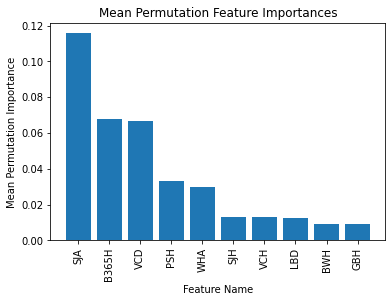

In [16]:
xtrain = odds_lr["train_data"][odds_features]
ytrain = odds_lr["train_data"][binary_class_label]
features_by_importance = get_sorted_importances(odds_lr, odds_features)
plot_sorted_importances(features_by_importance)

Re-train with the important features. Let's see what number of important features make the model perform the best.

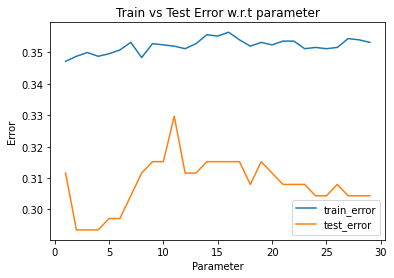

In [17]:
top_k = len(odds_features) # the number of top features to select

train_error = []
test_error = []
num_features = list(range(1, top_k))
for k in num_features:
    top_k_features = list(features_by_importance.head(k)["feature_name"])
    top_k_odds_lr = logistic_regression(odds_data[top_k_features + [binary_class_label]], top_k_features, suppress_print=True)
    tr_err, te_err = train_test_error(top_k_odds_lr, top_k_features, suppress_print=True)
    train_error.append(tr_err)
    test_error.append(te_err)

plot_errors(train_error, test_error, num_features)

We can note that picking the top 4 or 5 features minimizes test error. Train error stays relatively constant. Let's pick the top 4.

In [18]:
top_4_features = list(features_by_importance.head(4)["feature_name"])
top_4_features_odds_data = odds_data[top_4_features + [binary_class_label]]

We originally had some decent test/train error. Can we do even better? How about polynomial features on the important features? Attempt degree 2.

In [19]:
odds_poly = poly_enhance_data(top_4_features_odds_data, top_4_features, degree = 2, suppress_print=True)
odds_poly_lr = logistic_regression(odds_poly[0], odds_poly[1])

rmse = 0.29347826086956524
accuracy_score = 0.7065217391304348


In [20]:
train_test_error(odds_poly_lr, odds_poly[1])

Train Error = 0.34879032258064513
Test Error = 0.2934782608695652


(0.34879032258064513, 0.2934782608695652)

Going up to degree 3 increases error, so polynomial features isn't the way to go. Let's demonstrate this:

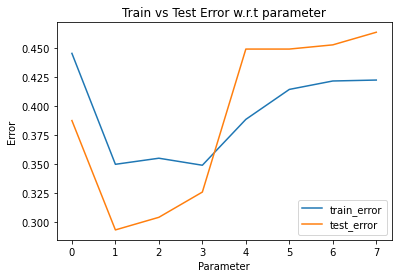

In [21]:
train_error = []
test_error = []
solver = "saga"
degrees = [i for i in range(8)]
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for degree in degrees:
        odds_poly = odds_poly = poly_enhance_data(top_4_features_odds_data, top_4_features, degree = degree, suppress_print=True)
        odds_poly_lr = logistic_regression(odds_poly[0], odds_poly[1], solver=solver, suppress_print=True)
        tr_err, te_err = train_test_error(odds_poly_lr, odds_poly[1], suppress_print=True)
        train_error.append(tr_err)
        test_error.append(te_err)

plot_errors(train_error, test_error, degrees)

Degree 1 seems to minimize train and test error, so we should just not use polynomial features. I'll settle at ~70% accuracy when training the model on betting odds. So, to conclude, the best four providers to use to predict match outcome are:

In [22]:
top_4_features

['SJA', 'B365H', 'VCD', 'PSH']

What this tells us is that when these providers release their odds, you can use them with our modelling with 70% accuracy. This model is represented in ```odds_predictor.py```. Here is a quick demo on how to use the predictor:

In [47]:
from odds_predictor import OddsPredictor
predictor = OddsPredictor(matches)
predictor.train()

rmse = 0.29347826086956524
accuracy_score = 0.7065217391304348
['SJA', 'VCD', 'B365H']


In [48]:
sample_match_odds = {
    "SJA": 8,
    "VCD": 0,
    "B365H": 3
}
predictor.will_home_win(sample_match_odds)

True

We have a 70% accurate predictor trained on match odds!

## 2. Team Match History

Are historically successful teams more likely to win a matchup?

Look at all matches before a given match for a given team and compute their cumulative goal differential win rate. Encode a matchup as home cumulative goal difference/win rate - away cumulative goal difference/win rate

This is pretty difficult...

## 3. FIFA Attributes

Use aggregated FIFA information from Team_Attributes to predict match outcomes.

In [25]:
team_attributes = pd.read_sql("SELECT * FROM Team_Attributes;", connection)

In [26]:
# Features to train the model on
buildup_features = ["buildUpPlaySpeed", "buildUpPlayDribbling", "buildUpPlayPassing"]
chance_creation_features = ["chanceCreationPassing", "chanceCreationCrossing", "chanceCreationShooting"]
defence_features = ["defencePressure", "defenceAggression", "defenceTeamWidth"]
categories = [buildup_features, chance_creation_features, defence_features]

aggregations = ["mean", "min", "max", "median"]

# Raw names
all_attr_features = []
for category in categories:
    all_attr_features += category

# Named aggregations
all_attr_features_agg = []
categories_agg = []
for category in categories:
    category_agg = []
    for agg in aggregations:
        for feature in category:
            formatted_feature_name = f"{feature}_{agg}"
            category_agg.append(formatted_feature_name)
            all_attr_features_agg.append(formatted_feature_name)
    categories_agg.append(category_agg)

len(all_attr_features_agg)

36

In [27]:
aggregated_attributes = team_attributes.groupby("team_api_id").agg(
    {feature : [(f"{feature}_{agg}", agg) for agg in aggregations]for feature in all_attr_features}
).reset_index(col_level = 1).droplevel(level = 0, axis = 1)[["team_api_id"] + all_attr_features_agg]

aggregated_attributes.head()

,team_api_id,buildUpPlaySpeed_mean,buildUpPlayDribbling_mean,buildUpPlayPassing_mean,buildUpPlaySpeed_min,buildUpPlayDribbling_min,buildUpPlayPassing_min,buildUpPlaySpeed_max,buildUpPlayDribbling_max,buildUpPlayPassing_max,...,defenceTeamWidth_mean,defencePressure_min,defenceAggression_min,defenceTeamWidth_min,defencePressure_max,defenceAggression_max,defenceTeamWidth_max,defencePressure_median,defenceAggression_median,defenceTeamWidth_median
0,1601,47.333333,48.0,46.166667,30,48.0,38,53,48.0,55,...,49.333333,43,44,49,65,60,50,43.0,44.0,49.0
1,1773,52.000000,51.0,50.000000,52,51.0,50,52,51.0,50,...,50.000000,43,44,50,43,44,50,43.0,44.0,50.0
2,1957,47.166667,54.0,52.666667,30,54.0,38,66,54.0,69,...,53.666667,32,50,49,70,70,70,48.5,56.0,51.0
3,2033,49.000000,62.0,48.400000,45,62.0,40,65,62.0,55,...,45.400000,37,24,35,50,45,60,37.0,31.0,44.0
4,2182,60.333333,52.5,49.000000,40,50.0,35,67,55.0,57,...,54.500000,47,37,45,60,58,63,48.5,47.0,55.5


In [28]:
def attribute_matchup(dataset, home_id, away_id):
    """
    Computes the matchup features for the home_id and away_id.
    """
    home = dataset[dataset["team_api_id"] == home_id][all_attr_features_agg].to_numpy()
    away = dataset[dataset["team_api_id"] == away_id][all_attr_features_agg].to_numpy()
    if len(home) == 0 or len(away) == 0:
        # Team not present, no matchup possible
        return pd.Series([np.nan] * len(all_attr_features_agg), index = all_attr_features_agg)
    diff = (home - away)[0]
    return pd.Series(diff, index = all_attr_features_agg)

Generate team attribute matchups. This cell took around 1 minute

In [29]:
attr_data = matches.copy()
attr_data[all_attr_features_agg] = attr_data.apply(lambda x: attribute_matchup(aggregated_attributes, x["home_team_api_id"], x["away_team_api_id"]), axis = 1, result_type = "expand")

In [30]:
attr_data = attr_data.dropna()
attr_data.shape

(1762, 153)

Train the model using all features

In [31]:
attr_lr = logistic_regression(attr_data, all_attr_features_agg)

rmse = 0.44886363636363635
accuracy_score = 0.5511363636363636


In [32]:
# Evaluate:
train_test_error(attr_lr, all_attr_features_agg)

Train Error = 0.36822194199243374
Test Error = 0.44886363636363635


(0.36822194199243374, 0.44886363636363635)

#### Selecting best features

We have pretty high test error (44%), which isn't very good. Let's use permutation feature importance to see the most significant team attribute features, and then retrain.

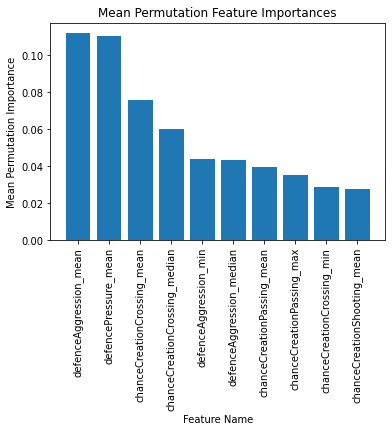

In [33]:
sorted_attr_importances = get_sorted_importances(attr_lr, all_attr_features_agg)
plot_sorted_importances(sorted_attr_importances)

In [52]:
top_k_attr_features = helpers.find_top_k_performing_important_features(attr_data, sorted_attr_importances)
top_k_attr_features[0]

['defenceAggression_mean',
 'defencePressure_mean',
 'chanceCreationCrossing_mean',
 'chanceCreationCrossing_median',
 'defenceAggression_min',
 'defenceAggression_median',
 'chanceCreationPassing_mean',
 'chanceCreationPassing_max',
 'chanceCreationCrossing_min',
 'chanceCreationShooting_mean']

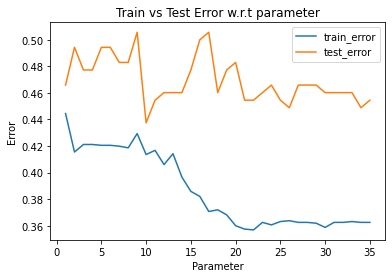

In [54]:
train_error, test_error, parameters = top_k_attr_features[1]
helpers.plot_errors(train_error, test_error, parameters)

Curious to see that the train error steadily decreases with more features, but test error has better performance using the top $k = 10$ features.

In [57]:
top_k_attr_lr = logistic_regression(attr_data[top_k_attr_features[0] + [binary_class_label]], top_k_attr_features[0], suppress_print=True)
train_test_error(top_k_attr_lr, top_k_attr_features[0])

Train Error = 0.4136191677175284
Test Error = 0.4375


(0.4136191677175284, 0.4375)

We see a slight drop in test error but increase in train error. For reference, this is what it was before:
```
Train Error = 0.36822194199243374
Test Error = 0.44886363636363635
```

We can't really get much better unfortunately.



#### Category experimentation

Can we manually pick the most important category and aggregation to improve the accuracy of the model?

Train per category

In [34]:
print("*** Buildup Play Features ***")
buildup_lr = logistic_regression(attr_data, categories_agg[0])
print("*** Chance Creation Features ***")
chance_creation_lr = logistic_regression(attr_data, categories_agg[1])
print("*** Defensive Play Features ***")
defence_lr = logistic_regression(attr_data, categories_agg[2])

*** Buildup Play Features ***
rmse = 0.42613636363636365
accuracy_score = 0.5738636363636364
*** Chance Creation Features ***
rmse = 0.4090909090909091
accuracy_score = 0.5909090909090909
*** Defensive Play Features ***
rmse = 0.5113636363636364
accuracy_score = 0.48863636363636365


Investigate best aggregation technique:

In [35]:
# Train using only mean chance creation
lrs = []
for aggregation in aggregations:
    print(f"*** {aggregation} ***")
    lrs.append(logistic_regression(attr_data, [f"{feature}_{aggregation}" for feature in chance_creation_features]))

*** mean ***
rmse = 0.44886363636363635
accuracy_score = 0.5511363636363636
*** min ***
rmse = 0.4318181818181818
accuracy_score = 0.5681818181818182
*** max ***
rmse = 0.375
accuracy_score = 0.625
*** median ***
rmse = 0.45454545454545453
accuracy_score = 0.5454545454545454


Max seems to be the best-performing aggregation. Pick the top 2 best performing features and retrain

In [36]:
max_cr_features = [f"{feature}_max" for feature in chance_creation_features]
# By trial and error 1 and 2 are the best
max_cr_features_top_two = [max_cr_features[1], max_cr_features[2]]

chance_creation_max_lr = logistic_regression(attr_data, max_cr_features_top_two)

test = chance_creation_max_lr["test_data"]
y_pred = chance_creation_max_lr["model"].predict(test[max_cr_features_top_two])

rmse = 0.3806818181818182
accuracy_score = 0.6193181818181818


Let's inspect the train and test errors in this prediction:

In [37]:
train_test_error(chance_creation_max_lr, max_cr_features_top_two)

Train Error = 0.43631778058007564
Test Error = 0.38068181818181823


(0.43631778058007564, 0.38068181818181823)

We have okay test and train error (44%, 38%). So, we are suffering from **underfitting** as error is still somewhat high. To improve underfitting, we introduce new features. To begin, we introduce polynomial features. We are initially using the following two features:

In [38]:
print(max_cr_features_top_two)

['chanceCreationCrossing_max', 'chanceCreationShooting_max']


In [39]:
# Select data
attr_data_relevant = attr_data[max_cr_features_top_two + [binary_class_label]]
attr_data_relevant.head()

,chanceCreationCrossing_max,chanceCreationShooting_max,home_team_win
3248,-17.0,-7.0,0
3249,-2.0,-7.0,1
3250,-6.0,-7.0,1
3251,0.0,10.0,1
3252,0.0,-10.0,1


In [40]:
poly_enhance_attr_cr_max = poly_enhance_data(attr_data_relevant, max_cr_features_top_two, degree = 5)
poly_attr_cr_max_data = poly_enhance_attr_cr_max[0]
poly_feats = poly_enhance_attr_cr_max[1]
poly_attr_cr_max_data.head()

Input data shape = (1762, 2)
Output data shape = (1762, 12)
10 new features generated of degree up to 5


,x_(0)^(0),x_(1)^(0),x_(0)^(1),x_(1)^(1),x_(0)^(2),x_(1)^(2),x_(0)^(3),x_(1)^(3),x_(0)^(4),x_(1)^(4),x_(0)^(5),x_(1)^(5),home_team_win
0,1.0,1.0,-17.0,-7.0,289.0,49.0,-4913.0,-343.0,83521.0,2401.0,-1419857.0,-16807.0,0
1,1.0,1.0,-2.0,-7.0,4.0,49.0,-8.0,-343.0,16.0,2401.0,-32.0,-16807.0,1
2,1.0,1.0,-6.0,-7.0,36.0,49.0,-216.0,-343.0,1296.0,2401.0,-7776.0,-16807.0,1
3,1.0,1.0,0.0,10.0,0.0,100.0,0.0,1000.0,0.0,10000.0,0.0,100000.0,1
4,1.0,1.0,0.0,-10.0,0.0,100.0,0.0,-1000.0,0.0,10000.0,0.0,-100000.0,1


Train a new LR model using the polynomial features

In [41]:
poly_lr = logistic_regression(poly_attr_cr_max_data, poly_feats)

rmse = 0.39204545454545453
accuracy_score = 0.6079545454545454


In [42]:
train_test_error(poly_lr, poly_feats)

Train Error = 0.4287515762925599
Test Error = 0.3920454545454546


(0.4287515762925599, 0.3920454545454546)

Using degree 5, we saw a drop in train error of around 2% but increase in test error by around 1%. 

## 4. Formation shape
Use unsupervised learning to categorize formations into narrow/wide, defensive/attacking, output "formation width index" and "formation aggressiveness index"